In [1]:
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from data_utils import *
from evaluate_cbf import *
from models import *
from train import *

%load_ext autoreload
%autoreload 2

In [35]:
# Initialize DataFrame for results

try:
    df_results = pd.read_csv('model_results.csv')
except FileNotFoundError:
    df_results = pd.DataFrame(columns=['Model', 'K', 'Recall', 'NDCG', 'ILD', 'F1'])

def update_results(model, k, recall, ndcg, ild, f1):
    global df_results
    df_results = df_results.append({
        'Model': model,
        'K': k,
        'Recall': recall,
        'NDCG': ndcg,
        'ILD': ild,
        'F1': f1
    }, ignore_index=True)
    df_results.to_csv('model_results.csv', index=False)


In [2]:
# Initialise global parameters

seed = 4242
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_num_threads(torch.get_num_threads())

emb_size = 100
lr = 0.001
dropout = 0.0
batch_size = 128
epochs = 50
device = "cpu"
top_k = [10,20,30,40,50,60,70,80,90,100]
log_name = "log"
num_categories = 368
num_visual_features = 512
embedding_dim = 64
hidden_dim = 64
diversity_param = 0


In [5]:
# Load data
user_num, item_num, train_dict, valid_dict, test_dict, train_data, valid_gt, test_gt, category_features, category_features_onehot, visual_features, train_user_profiles, valid_user_profiles, test_user_profiles = load_data()

Number of users: 506, Number of items: 1674
Training samples: 12358, Validation samples: 406, Test samples: 406
Category features shape: (1674, 368)
Visual features shape: (512,)


In [19]:
# Train CBF model

train_cbf('CBF', user_num, item_num, train_data, valid_dict, train_dict, category_features, category_features_onehot, visual_features, train_user_profiles, num_categories, num_visual_features, hidden_dim, [10,20,50,100], epochs, batch_size, lr, device, diversity_param)

Epoch 1, Loss: 0.695492816340063, Time elapsed: 28.90s


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


Top-10: Avg Recall: 0.0222, Avg NDCG: 0.0126, Avg ILD: 0.9935, Avg F1 Score: 0.0249
Top-20: Avg Recall: 0.0296, Avg NDCG: 0.0145, Avg ILD: 0.9926, Avg F1 Score: 0.0286
Top-50: Avg Recall: 0.0640, Avg NDCG: 0.0211, Avg ILD: 0.9876, Avg F1 Score: 0.0413
Top-100: Avg Recall: 0.1034, Avg NDCG: 0.0276, Avg ILD: 0.9907, Avg F1 Score: 0.0537
New best model saved with Average Recall: 0.05480295566502463, Average F1: 0.03708211685585695, model path: ./models/best_model_CBF.pth
------------------------------------------------------
Epoch 2, Loss: 0.6877829917927378, Time elapsed: 28.90s
Top-10: Avg Recall: 0.0222, Avg NDCG: 0.0117, Avg ILD: 0.9796, Avg F1 Score: 0.0231
Top-20: Avg Recall: 0.0296, Avg NDCG: 0.0135, Avg ILD: 0.9951, Avg F1 Score: 0.0267
Top-50: Avg Recall: 0.0739, Avg NDCG: 0.0219, Avg ILD: 0.9877, Avg F1 Score: 0.0429
Top-100: Avg Recall: 0.1305, Avg NDCG: 0.0312, Avg ILD: 0.9872, Avg F1 Score: 0.0604
New best model saved with Average Recall: 0.06403940886699508, Average F1: 0.03

In [32]:
# Test CBF model
cbf_model = ContentBasedModel(num_categories, num_visual_features, 32)
cbf_model.load_state_dict(torch.load('./models/best_model_CBF.pth'))
cbf_model.to(device)
cbf_model.eval()
recommends, results = metrics_cbf(cbf_model, top_k, train_dict, test_dict, test_user_profiles, category_features, category_features_onehot, visual_features, device, diversity_param, is_training=False)

for k in top_k:
    update_results('CBF', k, results[k]['Recall'], results[k]['NDCG'], results[k]['ILD'], results[k]['F1'])

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


Top-10: Avg Recall: 0.1281, Avg NDCG: 0.0594, Avg ILD: 0.9416, Avg F1 Score: 0.1118
Top-20: Avg Recall: 0.2118, Avg NDCG: 0.0805, Avg ILD: 0.9484, Avg F1 Score: 0.1483
Top-30: Avg Recall: 0.2660, Avg NDCG: 0.0920, Avg ILD: 0.9545, Avg F1 Score: 0.1678
Top-40: Avg Recall: 0.3054, Avg NDCG: 0.0996, Avg ILD: 0.9607, Avg F1 Score: 0.1805
Top-50: Avg Recall: 0.3547, Avg NDCG: 0.1084, Avg ILD: 0.9651, Avg F1 Score: 0.1950
Top-60: Avg Recall: 0.3867, Avg NDCG: 0.1140, Avg ILD: 0.9686, Avg F1 Score: 0.2039
Top-70: Avg Recall: 0.4409, Avg NDCG: 0.1229, Avg ILD: 0.9712, Avg F1 Score: 0.2182
Top-80: Avg Recall: 0.4729, Avg NDCG: 0.1280, Avg ILD: 0.9735, Avg F1 Score: 0.2263
Top-90: Avg Recall: 0.5000, Avg NDCG: 0.1323, Avg ILD: 0.9752, Avg F1 Score: 0.2329
Top-100: Avg Recall: 0.5197, Avg NDCG: 0.1353, Avg ILD: 0.9769, Avg F1 Score: 0.2376


/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.appen

Top-10: Avg Recall: 0.1281, Avg NDCG: 0.0594, Avg ILD: 0.9416, Avg F1 Score: 0.1118
Top-20: Avg Recall: 0.2118, Avg NDCG: 0.0805, Avg ILD: 0.9484, Avg F1 Score: 0.1483
Top-50: Avg Recall: 0.3547, Avg NDCG: 0.1084, Avg ILD: 0.9651, Avg F1 Score: 0.1950
Top-100: Avg Recall: 0.5197, Avg NDCG: 0.1353, Avg ILD: 0.9769, Avg F1 Score: 0.2376
Top-10: Avg Recall: 0.1281, Avg NDCG: 0.0590, Avg ILD: 0.9416, Avg F1 Score: 0.1110
Top-20: Avg Recall: 0.2118, Avg NDCG: 0.0780, Avg ILD: 0.9484, Avg F1 Score: 0.1441
Top-50: Avg Recall: 0.3547, Avg NDCG: 0.1032, Avg ILD: 0.9651, Avg F1 Score: 0.1864
Top-100: Avg Recall: 0.5197, Avg NDCG: 0.1281, Avg ILD: 0.9769, Avg F1 Score: 0.2265
Top-10: Avg Recall: 0.1281, Avg NDCG: 0.0590, Avg ILD: 0.9416, Avg F1 Score: 0.1110
Top-20: Avg Recall: 0.2118, Avg NDCG: 0.0779, Avg ILD: 0.9484, Avg F1 Score: 0.1439
Top-50: Avg Recall: 0.3547, Avg NDCG: 0.1028, Avg ILD: 0.9651, Avg F1 Score: 0.1857
Top-100: Avg Recall: 0.5197, Avg NDCG: 0.1270, Avg ILD: 0.9769, Avg F1 Sco

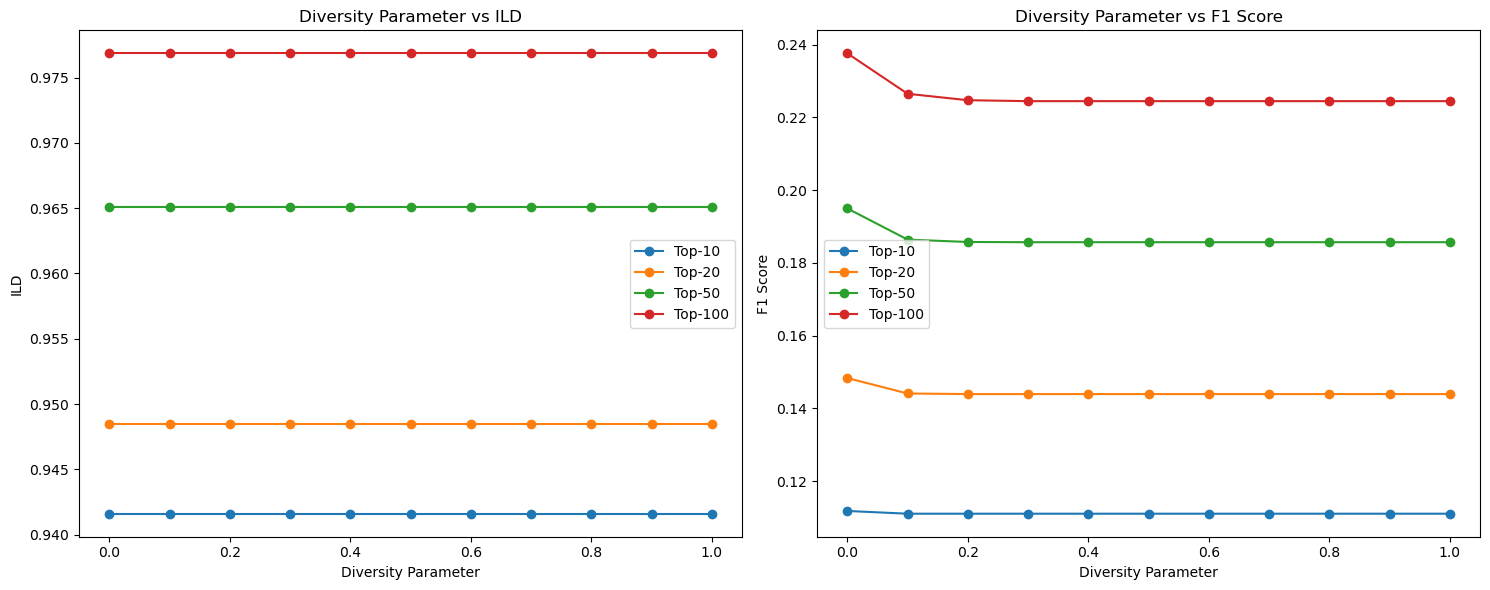

In [12]:
# Test the CBF model with different diversity parameters

diversity_params = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1_scores = {k: [] for k in top_k}
ild_scores = {k: [] for k in top_k}

for diversity_param in diversity_params:
    model = ContentBasedModel(num_categories, num_visual_features, 32)
    model.load_state_dict(torch.load("./models/best_model_CBF.pth"))
    model.to(device)
    _, results = metrics_cbf(model, [10,20,50,100], train_dict, test_dict, test_user_profiles, category_features, category_features_onehot, visual_features, device, diversity_param, is_training=False)
    for k in top_k:
        f1_scores[k].append(results[k]['F1'])
        ild_scores[k].append(results[k]['ILD'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ILD Score on the first subplot
for k in top_k:
    ax1.plot(diversity_params, ild_scores[k], label=f'Top-{k}', marker='o')
ax1.set_title('Diversity Parameter vs ILD')
ax1.set_xlabel('Diversity Parameter')
ax1.set_ylabel('ILD')
ax1.legend()
ax1.grid(False)

# Plot F1 Score on the second subplot
for k in top_k:
    ax2.plot(diversity_params, f1_scores[k], label=f'Top-{k}', marker='o')
ax2.set_title('Diversity Parameter vs F1 Score')
ax2.set_xlabel('Diversity Parameter')
ax2.set_ylabel('F1 Score')
ax2.legend()
ax2.grid(False)

plt.tight_layout()
plt.show()

In [20]:
# Train MF model
train_cf('MF', user_num, item_num, train_data, valid_dict, train_dict, category_features, emb_size, [10,20,50,100], epochs, batch_size, lr, device, dropout=0.1)

Epoch 1, Loss: 0.6932187513592317, Time elapsed: 7.78s
Top-10: Avg Recall: 0.0433, Avg NDCG: 0.0221, Avg ILD: 0.9903, Avg F1 Score: 0.0831
Top-20: Avg Recall: 0.0464, Avg NDCG: 0.0229, Avg ILD: 0.9921, Avg F1 Score: 0.0887
Top-50: Avg Recall: 0.0836, Avg NDCG: 0.0299, Avg ILD: 0.9942, Avg F1 Score: 0.1542
Top-100: Avg Recall: 0.1084, Avg NDCG: 0.0339, Avg ILD: 0.9949, Avg F1 Score: 0.1954
New best model saved with Average Recall: 0.07043343653250775, Average F1: 0.13035711869467473, model path: ./models/best_model_MF.pth
------------------------------------------------------
Epoch 2, Loss: 1.3804793382428355, Time elapsed: 7.65s
Top-10: Avg Recall: 0.0310, Avg NDCG: 0.0206, Avg ILD: 0.9986, Avg F1 Score: 0.0601
Top-20: Avg Recall: 0.0495, Avg NDCG: 0.0252, Avg ILD: 0.9966, Avg F1 Score: 0.0944
Top-50: Avg Recall: 0.0774, Avg NDCG: 0.0305, Avg ILD: 0.9959, Avg F1 Score: 0.1436
Top-100: Avg Recall: 0.1146, Avg NDCG: 0.0364, Avg ILD: 0.9956, Avg F1 Score: 0.2055
--------------------------

In [23]:
# Test MF model

mf_model = MF(user_num, item_num, emb_size, dropout)
mf_model.load_state_dict(torch.load(f'./models/best_model_MF.pth'))
mf_model.to(device)
mf_model.eval()
recommends, results = metrics(model, top_k, train_dict, test_dict, test_dict, item_num, 0, category_features, device)

for k in top_k:
    update_results('MF', k, results[k]['Recall'], results[k]['NDCG'], results[k]['ILD'], results[k]['F1'])
    

Top-10: Avg Recall: 0.0093, Avg NDCG: 0.0057, Avg ILD: 0.9889, Avg F1 Score: 0.0184
Top-20: Avg Recall: 0.0186, Avg NDCG: 0.0080, Avg ILD: 0.9897, Avg F1 Score: 0.0365
Top-30: Avg Recall: 0.0217, Avg NDCG: 0.0086, Avg ILD: 0.9904, Avg F1 Score: 0.0424
Top-40: Avg Recall: 0.0310, Avg NDCG: 0.0104, Avg ILD: 0.9911, Avg F1 Score: 0.0600
Top-50: Avg Recall: 0.0372, Avg NDCG: 0.0115, Avg ILD: 0.9914, Avg F1 Score: 0.0716
Top-60: Avg Recall: 0.0495, Avg NDCG: 0.0136, Avg ILD: 0.9919, Avg F1 Score: 0.0944
Top-70: Avg Recall: 0.0588, Avg NDCG: 0.0152, Avg ILD: 0.9920, Avg F1 Score: 0.1111
Top-80: Avg Recall: 0.0681, Avg NDCG: 0.0166, Avg ILD: 0.9921, Avg F1 Score: 0.1275
Top-90: Avg Recall: 0.0712, Avg NDCG: 0.0171, Avg ILD: 0.9923, Avg F1 Score: 0.1329
Top-100: Avg Recall: 0.0774, Avg NDCG: 0.0181, Avg ILD: 0.9924, Avg F1 Score: 0.1436


/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.appen

In [21]:
# Train NCF model
train_cf('NCF', user_num, item_num, train_data, valid_dict, train_dict, category_features, emb_size, [10,20,50,100], epochs, batch_size, lr, device, dropout=0.1)

Epoch 1, Loss: 0.7040181737585166, Time elapsed: 7.94s
Top-10: Avg Recall: 0.0557, Avg NDCG: 0.0249, Avg ILD: 0.9893, Avg F1 Score: 0.1055
Top-20: Avg Recall: 0.0619, Avg NDCG: 0.0265, Avg ILD: 0.9942, Avg F1 Score: 0.1166
Top-50: Avg Recall: 0.0898, Avg NDCG: 0.0319, Avg ILD: 0.9953, Avg F1 Score: 0.1647
Top-100: Avg Recall: 0.1238, Avg NDCG: 0.0374, Avg ILD: 0.9961, Avg F1 Score: 0.2203
New best model saved with Average Recall: 0.08281733746130031, Average F1: 0.1517722782532041, model path: ./models/best_model_NCF.pth
------------------------------------------------------
Epoch 2, Loss: 1.389553764431747, Time elapsed: 7.83s
Top-10: Avg Recall: 0.0495, Avg NDCG: 0.0236, Avg ILD: 0.9800, Avg F1 Score: 0.0943
Top-20: Avg Recall: 0.0712, Avg NDCG: 0.0291, Avg ILD: 0.9936, Avg F1 Score: 0.1329
Top-50: Avg Recall: 0.0805, Avg NDCG: 0.0309, Avg ILD: 0.9950, Avg F1 Score: 0.1489
Top-100: Avg Recall: 0.1207, Avg NDCG: 0.0374, Avg ILD: 0.9958, Avg F1 Score: 0.2154
---------------------------

In [22]:
# Test NCF model

ncf_model = NCF(user_num, item_num, emb_size, dropout)
ncf_model.load_state_dict(torch.load(f'./models/best_model_NCF.pth'))
ncf_model.to(device)
ncf_model.eval()
recommends, results = metrics(ncf_model, top_k, train_dict, test_dict, test_dict, item_num, 0, category_features, device)

for k in top_k:
    update_results(ncf_model.model_name, k, results[k]['Recall'], results[k]['NDCG'], results[k]['ILD'], results[k]['F1'])

Top-10: Avg Recall: 0.0248, Avg NDCG: 0.0114, Avg ILD: 0.9981, Avg F1 Score: 0.0483
Top-20: Avg Recall: 0.0402, Avg NDCG: 0.0152, Avg ILD: 0.9904, Avg F1 Score: 0.0774
Top-30: Avg Recall: 0.0433, Avg NDCG: 0.0159, Avg ILD: 0.9912, Avg F1 Score: 0.0831
Top-40: Avg Recall: 0.0495, Avg NDCG: 0.0171, Avg ILD: 0.9902, Avg F1 Score: 0.0944
Top-50: Avg Recall: 0.0867, Avg NDCG: 0.0238, Avg ILD: 0.9920, Avg F1 Score: 0.1594
Top-60: Avg Recall: 0.1084, Avg NDCG: 0.0276, Avg ILD: 0.9934, Avg F1 Score: 0.1954
Top-70: Avg Recall: 0.1084, Avg NDCG: 0.0276, Avg ILD: 0.9935, Avg F1 Score: 0.1954
Top-80: Avg Recall: 0.1269, Avg NDCG: 0.0305, Avg ILD: 0.9943, Avg F1 Score: 0.2251
Top-90: Avg Recall: 0.1362, Avg NDCG: 0.0320, Avg ILD: 0.9941, Avg F1 Score: 0.2396
Top-100: Avg Recall: 0.1455, Avg NDCG: 0.0334, Avg ILD: 0.9944, Avg F1 Score: 0.2539


/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/6l/xwrqvy7n1814gqhygtglkblw0000gn/T/ipykernel_94194/1044627896.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.appen

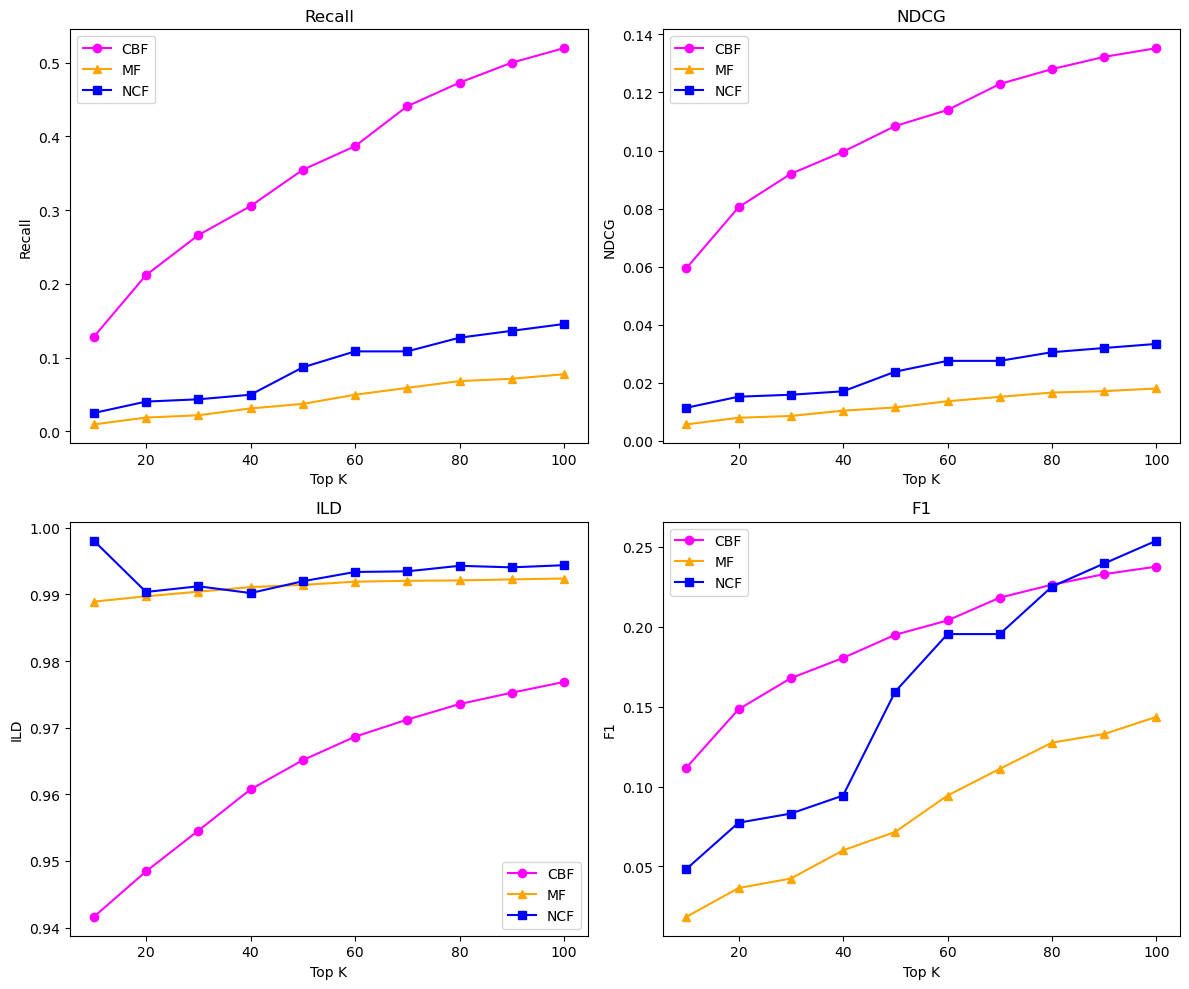

In [36]:
# Compare results of different models

# Load the data
df = pd.read_csv('model_results.csv')

# Splitting the DataFrame based on the model
data_cbf = df[df['Model'] == 'CBF']
data_mf = df[df['Model'] == 'MF']
data_ncf = df[df['Model'] == 'NCF']

# Define the metrics to plot
evaluation_metrics = ['Recall', 'NDCG', 'ILD', 'F1']

# Initialize a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flattening the array of axes for easy iterating
axs = axs.flatten()

colors = {'CBF': 'magenta', 'MF': 'orange', 'NCF': 'blue'}

# Loop through each metric and plot
for i, metric in enumerate(evaluation_metrics):
    axs[i].plot(data_cbf['K'], data_cbf[metric], label='CBF', color=colors['CBF'], marker='o')
    axs[i].plot(data_mf['K'], data_mf[metric], label='MF', color=colors['MF'], marker='^')
    axs[i].plot(data_ncf['K'], data_ncf[metric], label='NCF', color=colors['NCF'], marker='s')
    
    axs[i].set_title(metric)
    axs[i].set_xlabel('Top K')
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(False)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
